Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.
Found 624 files belonging to 2 classes.
Loaded Classes: ['NORMAL', 'PNEUMONIA']
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 33s 239ms/step - accuracy: 0.8531 - loss: 0.3252 - recall: 0.8662 - val_accuracy: 0.8677 - val_loss: 0.2422 - val_recall: 0.9963
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 32s 245ms/step - accuracy: 0.9272 - loss: 0.1880 - recall: 0.9504 - val_accuracy: 0.9521 - val_loss: 0.1299 - val_recall: 0.9840
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 33s 252ms/step - accuracy: 0.9319 - loss: 0.1764 - recall: 0.9579 - val_accuracy: 0.9597 - val_loss: 0.1114 - val_recall: 0.9654
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 35s 264ms/step - accuracy: 0.9384 - loss: 0.1564 - recall: 0.9579 - val_accuracy: 0.9549 - val_loss: 0.1172 - val_recall: 0.9568
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 36s 272ms

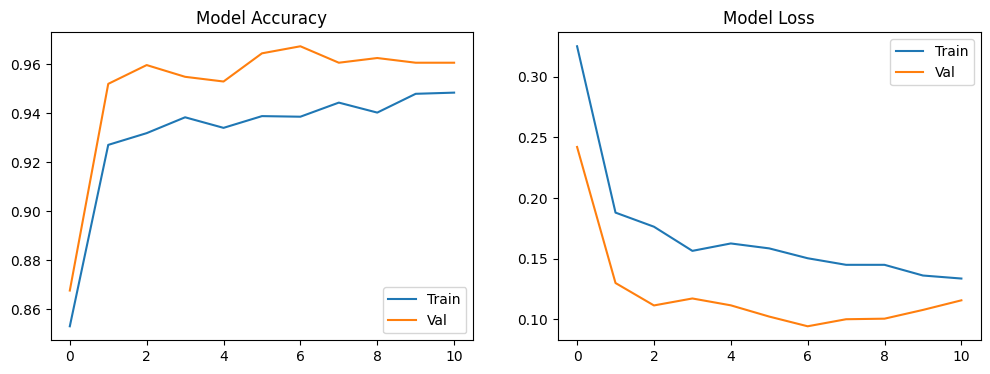

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step

--- Final Classification Report ---
              precision    recall  f1-score   support

      NORMAL       0.97      0.53      0.69       234
   PNEUMONIA       0.78      0.99      0.87       390

    accuracy                           0.82       624
   macro avg       0.87      0.76      0.78       624
weighted avg       0.85      0.82      0.80       624



2026-01-20 11:06:27.905518: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


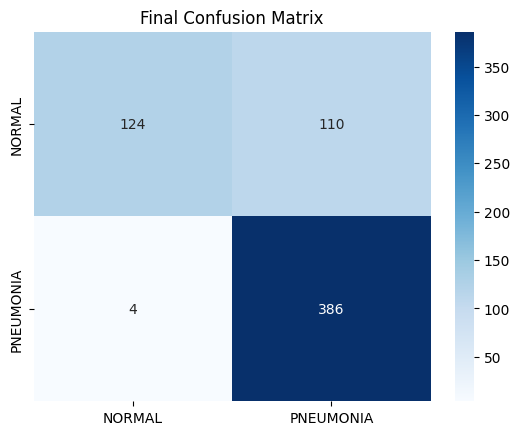

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# =========================
# 1. Constants & Paths
# =========================
TRAIN_DIR = "../data/chest_xray/train"
TEST_DIR  = "../data/chest_xray/test"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# =========================
# 2. Data Loading (Fixing the Val Set)
# =========================
# We use validation_split=0.2 on the TRAIN folder because the 
# original VAL folder is too small (only 16 images).
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    shuffle=False
)

class_names = train_ds.class_names
print(f"Loaded Classes: {class_names}")

# =========================
# 3. Preprocessing & Augmentation
# =========================
def prepare_data(ds, augment=False):
    # Rescaling 1/255 is handled inside the model or here
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

train_ds = prepare_data(train_ds, augment=True)
val_ds   = prepare_data(val_ds)
test_ds  = prepare_data(test_ds)

# =========================
# 4. Model (Transfer Learning)
# =========================
# We use MobileNetV2: lightweight and very powerful for medical imaging
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # Freeze the pre-trained weights

model = keras.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Rescaling(1./127.5, offset=-1), # MobileNetV2 expects [-1, 1]
    
    # Data Augmentation to prevent overfitting
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    
    base_model,
    
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.4),  # High dropout for small datasets
    layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.Recall(name="recall")]
)

# =========================
# 5. Training & Callbacks
# =========================
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=4, restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop]
)

# =========================
# 6. Evaluation & Visualization
# =========================
def plot_results(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(history.history['accuracy'], label='Train')
    ax1.plot(history.history['val_accuracy'], label='Val')
    ax1.set_title('Model Accuracy')
    ax1.legend()
    
    ax2.plot(history.history['loss'], label='Train')
    ax2.plot(history.history['val_loss'], label='Val')
    ax2.set_title('Model Loss')
    ax2.legend()
    plt.show()

plot_results(history)

# Final Test Metrics
y_pred_probs = model.predict(test_ds)
y_pred = (y_pred_probs > 0.5).astype(int)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

print("\n--- Final Classification Report ---")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title("Final Confusion Matrix")
plt.show()